## Data Preparation

In [2]:
import pandas as pd
train_df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
display(train_df.tail())

print(f'\n# of Unique EEG: {len(train_df.eeg_id.unique())}')
print(f'# of Unique Spectrogram: {len(train_df.spectrogram_id.unique())}')
print(f'# of Unique Patients: {len(train_df.patient_id.unique())}')

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0
106799,351917269,10,20.0,2147388374,10,20.0,3642716176,10351,LRDA,0,0,0,3,0,0



# of Unique EEG: 17089
# of Unique Spectrogram: 11138
# of Unique Patients: 1950


**Observations:**

1. Multiple eeg_ids may have the same spectrogram_id.
2. Same eeg_id may have the multiple targets.
3. There can be different targets for the same spectrogram_id depending on the time intervals during which they were observed.

For each unique target in eeg_id, Let's get corresponding spectrogram_id along with the time interval (min and max of spectrogram_label_offset_seconds) during which a specific brain activity was detected.

In [3]:
# Group by 'eeg_id' and targets compute the minimum and maximum values of 'spectrogram_label_offset_seconds'
group_by_cols = [
    'eeg_id', 'seizure_vote', 'lpd_vote',
    'gpd_vote', 'lrda_vote', 'grda_vote',
    'other_vote'
]

temp1 = train_df.groupby(group_by_cols).agg(
    min_offset_eeg=("eeg_label_offset_seconds", "min"),
    max_offset_eeg=("eeg_label_offset_seconds", "max"),
    min_offset_spec=("spectrogram_label_offset_seconds", "min"),
    max_offset_spec=("spectrogram_label_offset_seconds", "max")
).reset_index()


# Columns to Aggregate by first value
columns_to_keep = [
    'spectrogram_id', 'patient_id', 'expert_consensus', 'label_id'
    #'seizure_vote', 'lpd_vote','gpd_vote',
    #'lrda_vote', 'grda_vote', 'other_vote'
]

temp2 = train_df.groupby(group_by_cols)[columns_to_keep].agg('first')

# Merge based on the 'eeg_id' and targets
train_df = pd.merge(temp1, temp2, on=group_by_cols, how='inner')

# Convert targets into probabilities.
TARGETS = [
    'seizure_vote', 'lpd_vote', 'gpd_vote',
    'lrda_vote', 'grda_vote', 'other_vote'
]
row_sum = train_df[TARGETS].sum(axis=1)
train_df[TARGETS] = train_df[TARGETS].div(row_sum, axis=0)

# Rename the expert_consensus column to target.
train_df.rename(columns={'expert_consensus': 'target'}, inplace=True)

# Display
display(train_df.tail(5))

# Perform garbage collection
import gc

del temp1, temp2, row_sum
gc.collect()

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,min_offset_eeg,max_offset_eeg,min_offset_spec,max_offset_spec,spectrogram_id,patient_id,target,label_id
20178,4293354003,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,0.0,0.0,1188113564,16610,GRDA,447244163
20179,4293843368,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,0.0,0.0,1549502620,15065,GRDA,1618953053
20180,4294455489,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,2105480289,56,Other,469526364
20181,4294858825,0.0,0.0,0.0,0.0,0.066667,0.933333,0.0,12.0,0.0,12.0,657299228,4312,Other,561576493
20182,4294958358,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,2508.0,2508.0,260520016,25986,Other,2788887007


0

Total unique Training data based on the eeg_id and targets are: 20183

Since i am going to train the model on Spectrogram images (Following the footsteps of CHRIS DEOTTE and TAWARA), Lets read a spectrogram file and convert it to image to see how it looks.

a.k.a Visualization

Before this, Let me drop few quick knowledge bombs for better digestion of the things :p

* The spectrogram can be seen as a three-way plot of time on the x axis, frequency on the y axis, and power as color. [Link]

* Each spectrogram image has four panels: left lateral (LL), right lateral (RL), left parasagittal (LP), right parasagittal (RP).[Link] Each panel will correspond to 1 image so for a single spectrogram, we have a total of 4 images.

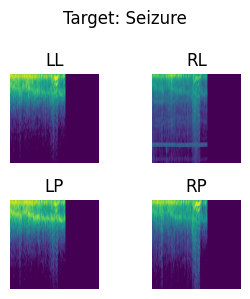

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Randomly sample a row from df
sample_row = train_df.sample(1)
spec_id = sample_row.iloc[0]['spectrogram_id']    
target = sample_row.iloc[0]['target']

# Read spectrogram file
spec = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/{spec_id}.parquet')
spec_arr = spec.fillna(0).values[:, 1:].T.astype("float32") # Fill nan value with zero

# Let's get the image for each panel.
PANELS = ['LL', 'RL', 'LP', 'RP']

# Calculate the number of rows and columns for the subplot
num_rows = 2
num_cols = 2

# Adjust the figsize accordingly
fig, ax = plt.subplots(num_rows, num_cols, figsize=(3, 3))

# Flatten the axes array if needed for easy indexing
ax = ax.flatten()

for (idx, panel) in enumerate(PANELS):
    img = spec_arr[100 * idx: 100 * idx + 100, :]

    # log transform (Taken from TAWARA Notebook)
    img = np.clip(img, np.exp(-4), np.exp(8))
    img = np.log(img)

    # normalize per image
    eps = 1e-6
    img_mean = img.mean(axis=(0, 1))
    img = img - img_mean
    img_std = img.std(axis=(0, 1))
    img = img / (img_std + eps)
    
    # Resize for visualize purpose
    img = cv2.resize(img, (128, 128))

    # Plot
    ax[idx].imshow(img)
    ax[idx].set_title(f'{panel}')
    ax[idx].axis('off')

fig.suptitle(f'Target: {target}', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

Let's prepare the data for training by splitting it into 5-folds for submission. We'll allocate the data to each fold based on the patient_id.

In [5]:
from sklearn.model_selection import StratifiedGroupKFold
N_FOLDS = 5
RANDAM_SEED = 42

sgkf = StratifiedGroupKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDAM_SEED)

train_df["fold"] = -1

for fold_id, (_, val_idx) in enumerate(
    sgkf.split(train_df, y=train_df["target"], groups=train_df["patient_id"])
):
    train_df.loc[val_idx, "fold"] = fold_id
    
# Display
display(train_df.tail(5))

print('\nFoldwise Training Data: \n')
print(train_df['fold'].value_counts())

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,min_offset_eeg,max_offset_eeg,min_offset_spec,max_offset_spec,spectrogram_id,patient_id,target,label_id,fold
20178,4293354003,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,0.0,0.0,1188113564,16610,GRDA,447244163,1
20179,4293843368,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,0.0,0.0,1549502620,15065,GRDA,1618953053,0
20180,4294455489,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,2105480289,56,Other,469526364,1
20181,4294858825,0.0,0.0,0.0,0.0,0.066667,0.933333,0.0,12.0,0.0,12.0,657299228,4312,Other,561576493,2
20182,4294958358,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,2508.0,2508.0,260520016,25986,Other,2788887007,3



Foldwise Training Data: 

fold
1    4372
4    4279
3    4268
2    3685
0    3579
Name: count, dtype: int64


In [6]:
# READ ALL SPECTROGRAMS
spectrograms = np.load('/kaggle/input/hbac-eeg-spectrograms/eeg_specs.npy',allow_pickle=True).item()
print(f'# of Total Spectrograms: {len(spectrograms)}')

# of Total Spectrograms: 20183


## Utilities

In [7]:
import torch
from torch.utils.data import Dataset

class HBACDataset(Dataset):
    
    def __init__(self, 
                 df, 
                 specs = spectrograms, 
                 mode = 'train',
                 transform = None # Augmentations
                ):
        self.df = df
        self.specs = specs
        self.mode = mode
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    '''Normalize the Spectrogram Image'''
    def _normalize(self, img):
        # LOG TRANSFORM SPECTROGRAM
        img = np.clip(img, np.exp(-4), np.exp(8))
        img = np.log(img)
        # STANDARDIZE PER IMAGE
        ep = 1e-6
        m = np.nanmean(img.flatten())
        s = np.nanstd(img.flatten())
        img = (img - m) / (s + ep)
        img = np.nan_to_num(img, nan=0.0)
        return img
    
    
    def __getitem__(self, idx):
        
        # Get the Spectrogram Interval of the Particular Activity.
        minimum_eeg = self.df['min_offset_eeg'].iloc[idx]
        maximum_eeg = self.df['max_offset_eeg'].iloc[idx]
        eeg_id = self.df.iloc[idx]['eeg_id']
        key = f'{eeg_id}_{int(minimum_eeg)}_{int(maximum_eeg)}'
        
        input_img = []
        X = np.zeros((4, 128, 256),  dtype=np.float32)
        for k in range(4):
            # EXTRACT 300 ROWS OF SPECTROGRAM
            img = self.specs[key][:,:,k]
            X[k, :, :] = img
            input_img.append(img)
        
        input_img = np.vstack(input_img)
        
        # Percentiles
        X_20p = np.percentile(X, q=20, axis=0)
        X_40p = np.percentile(X, q=40, axis=0)
        X_60p = np.percentile(X, q=60, axis=0)
        X_80p = np.percentile(X, q=80, axis=0)
        X_median = np.vstack([X_20p, X_40p, X_60p, X_80p])
        
        input_img = np.hstack([input_img, X_median])
        
        input_img = input_img[..., None] # Hz x Time x Channel
        
        if self.transform is not None:
            input_img = self.transform(image=input_img)["image"]
            
            
        labels = self.df.iloc[idx][TARGETS].values.astype(np.float32)
        
        return {"data": input_img, "target": torch.tensor(labels)}

Let's create a model that we are going to use for Training.

Among the shared code within the community for this competition, ResNet34 and EfficientNet emerge as the most prominent models with the highest public score notebooks.

We'll start our exploration with these models.

Code Reference: HMS-HBAC: ResNet34d Baseline [Training]

In [8]:
import timm
import torch.nn as nn

class HBACSpecModel(nn.Module):
    
    def __init__(
        self,
        model_name: str,
        pretrained: bool,
        in_channels: int,
        num_classes: int,
        drop_path_rate: float,
        drop_rate: float
    ):
        
        super().__init__()
        self.model = timm.create_model(
            model_name=model_name, 
            pretrained=pretrained,
            num_classes=num_classes, 
            in_chans=in_channels, 
            drop_path_rate = drop_path_rate
        )
        
        # Input Features
        in_features = self.model.classifier.in_features
        
        # Add Dropout
        self.model.classifier = nn.Sequential(
            nn.Dropout(drop_rate), 
            nn.Linear(in_features, num_classes, bias=True)
        )
        
    def forward(self, x):
        x = self.model(x)      
        return x

Since KLDivLoss align with the competition metric, we will use KLDiv Loss as Loss Function.

In [9]:
class KLDivLossWithLogits(nn.KLDivLoss):

    def __init__(self):
        super().__init__(reduction="batchmean")

    def forward(self, y, t):
        y = nn.functional.log_softmax(y,  dim=1)
        loss = super().forward(y, t)

        return loss

3321

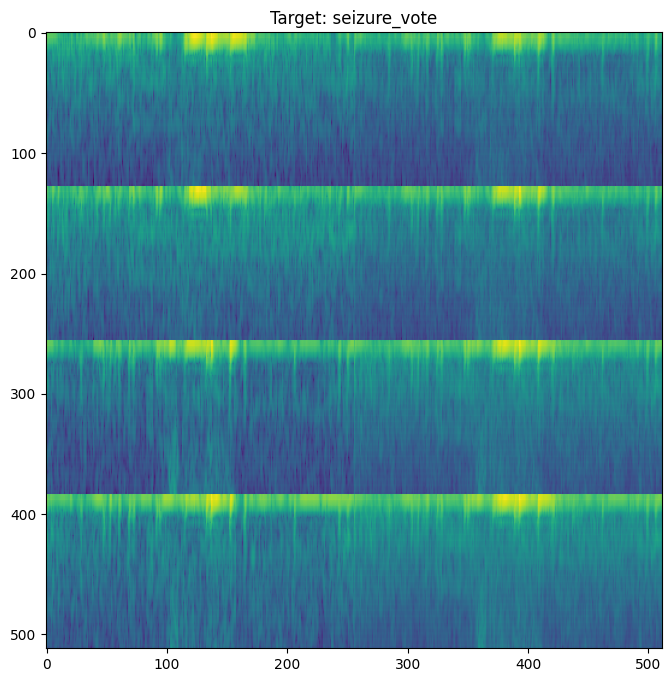

In [16]:
# Test
import random

# Initialize Dataset Class
ds = HBACDataset(train_df)

# Get a sample
sample = ds[random.randint(0, len(ds))]

# Get Data and Label from sample
data = sample['data']
label = TARGETS[sample['target'].argmax().item()]

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(data)
plt.title(f'Target: {label}')

# Garbage Collection
del ds, data, label
gc.collect()

## Training

In [18]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from torch.nn.parallel import DataParallel
from torch import optim
from torch.optim import lr_scheduler

# Check if GPU is available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'DEVICE: {device}\n')

# Transformations
train_transform = A.Compose([
    ToTensorV2(p=1.0)
])

val_transform = A.Compose([
    ToTensorV2(p=1.0)
])
    
# Loop through all folds. (5-Fold)
for fold in range(5):
    print('----------------------------------------------------------')
    print(f'\nFold: {fold}')
    
    # Train-Valid Split for the Fold
    train = train_df[train_df['fold'] != fold].reset_index(drop=True)
    valid = train_df[train_df['fold'] == fold].reset_index(drop=True)
    
    # Dataset
    train_ds = HBACDataset(train, transform=train_transform, mode='train')
    valid_ds = HBACDataset(valid, transform=val_transform, mode='valid')

    print(f'Train - {len(train_ds)}, Test - {len(valid_ds)}')
    
    # Dataloader
    batch_size = 32
    train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
    
    # Initialize the Model
    model = HBACSpecModel(model_name='efficientnet_b2', 
                          pretrained=True, 
                          in_channels=1, 
                          num_classes=6,
                          drop_path_rate = 0.2,
                          drop_rate = 0.3
                         )
    
    # Used for Mixed Precision Training
    scaler = GradScaler()

    # Move your model to the GPU and wrap it with DataParallel (To utilize T4X2)
    model = model.to(device)
    model = DataParallel(model)
    
    # Loss Function
    loss_func = KLDivLossWithLogits()

    # Prepare optimizer
    optimizer = optim.AdamW(model.parameters(),
                            lr=1.0e-03,
                            weight_decay = 1.0e-02
                           )
    NUM_EPOCHS = 6

    # 1cycle policy
    scheduler = lr_scheduler.OneCycleLR(
            optimizer=optimizer, epochs=NUM_EPOCHS,
            pct_start=0.0, steps_per_epoch=len(train_dataloader),
            max_lr=1.0e-03, div_factor=25, final_div_factor=4.0e-01
        )

    best_eval_loss = float('inf')  # Initialize the best evaluation loss to infinity

    # Do Evaluation 2 Times in every Epochs
    doEval = False
    eval_step = len(train_dataloader)//2 - 1
    
    print('\n--------------------------------------------')
    print(f'\033[93mEpoch    Step     Train-Loss   Valid-Loss\033[0m')
    print('--------------------------------------------')
    
    for epoch in range(NUM_EPOCHS):
        
        total_loss = 0
        
        for (batch_idx, batch) in enumerate(train_dataloader):
            model.train() # Set the model to Training mode
            with autocast():
                inputs = batch['data'].to(device)
                labels = batch['target'].to(device)

                # Forward loop
                optimizer.zero_grad() # Ensures Gradient doesn't accumulate.

                predictions = model(inputs.float())

                # Compute KLDIV loss
                loss = loss_func(predictions, labels)

            # BackProp
            scaler.scale(loss).backward()  # Scale the loss value
            scaler.step(optimizer)
            scaler.update()

            # Accumulate the Loss
            total_loss += loss.item()

            if (batch_idx != 0) and (batch_idx%eval_step == 0):
                # Calculate epoch-level metrics
                epoch_loss = total_loss / len(train_dataloader)

                # Evaluation
                model.eval()  # Set model to evaluation mode
                eval_loss = 0

                with torch.no_grad():
                    for batch in valid_dataloader:
                        with autocast():
                            inputs = batch['data'].to(device)
                            labels = batch['target'].to(device)

                            predictions = model(inputs.float())
                            loss = loss_func(predictions, labels)

                            eval_loss += loss.item()

                # Calculate evaluation metrics
                eval_epoch_loss = eval_loss / len(valid_dataloader)

                print(f'{epoch+1:<10} {(batch_idx//eval_step):<8} {epoch_loss:<10.4f}', end = "   ")

                # Save the Best Model
                if eval_epoch_loss < best_eval_loss:
                    best_eval_loss = eval_epoch_loss
                    print(f'\033[32m{best_eval_loss:<10.4f}\033[0m')
                    # Access the actual model from the DataParallel object
                    actual_model = model.module
                    # Save
                    torch.save(actual_model, f'fold_{fold}.pth')

                else:
                    print(f'\033[31m{eval_epoch_loss:<10.4f}\033[0m')
                        
                        
    # Memory Management
    del train_ds, valid_ds, train_dataloader, valid_dataloader, model, actual_model
    gc.collect()
    torch.cuda.empty_cache()

DEVICE: cuda

----------------------------------------------------------

Fold: 0
Train - 16604, Test - 3579

--------------------------------------------
Epoch    Step     Train-Loss   Valid-Loss
--------------------------------------------
1          1        0.4287       0.7637    
1          2        0.7924       0.7943    
2          1        0.3266       0.7533    
2          2        0.6419       0.6916    
3          1        0.2942       0.7625    
3          2        0.5903       0.7861    
4          1        0.2749       0.6797    
4          2        0.5542       0.6961    
5          1        0.2543       0.6854    
5          2        0.5162       0.7369    
6          1        0.2317       0.7221    
6          2        0.4717       0.7146    
----------------------------------------------------------

Fold: 1
Train - 15811, Test - 4372

--------------------------------------------
Epoch    Step     Train-Loss   Valid-Loss
--------------------------------------------
1 

In [ ]:
## EEG | EEG + Percentiles
# Fold-1: 0.7040 0.6797
# Fold-2: 0.7809 0.7495   
# Fold-3: 0.7618 0.6837
# Fold-4: 0.7791 0.7402
# Fold-5: 0.7294 0.6901
# OOF/LB: 0.7528 0.7104

## OOF-CV

In [20]:
from tqdm import tqdm

label_arr = train_df[TARGETS].values
oof_pred_arr = np.zeros((len(train_df), 6))

for fold in range(5):
    
    # Get valid Dataloader
    valid = train_df[train_df['fold'] == fold].reset_index()
    valid_ds = HBACDataset(valid, transform=val_transform)
    valid_dataloader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
    
    # Get Model
    model = torch.load(f'fold_{fold}.pth')
    
    # Run Inference
    model.to(device)
    model.eval()
    pred_list = []
    with torch.no_grad():
        for batch in tqdm(valid_dataloader):
            x = batch["data"].to(device)
            y = model(x.float())
            pred_list.append(y.softmax(dim=1).detach().cpu().numpy())
        
    pred_arr = np.concatenate(pred_list)
    oof_pred_arr[valid['index'].values] = pred_arr
    
    del model, valid, valid_ds, valid_dataloader
    torch.cuda.empty_cache()
    gc.collect()

100%|██████████| 134/134 [01:53<00:00,  1.18it/s]


In [21]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

true = train_df[["label_id"] + TARGETS].copy()

oof = pd.DataFrame(oof_pred_arr, columns=TARGETS)
oof.insert(0, "label_id", train_df["label_id"])

cv_score = score(solution=true, submission=oof, row_id_column_name='label_id')
print('CV Score KL-Div for EfficientNet-B2',cv_score)

CV Score KL-Div for EfficientNet-B2 0.7104483984499875


**1. Efficientnet-b2 + EEG Spectrograms + Percentiles**

<style>
table {
    width: 100%;
    border-collapse: collapse;
}

th, td {
    padding: 8px;
    text-align: left;
}

th {
    background-color: #FF0000; /* Red color */
    color: white;
}
</style>

<table>
    <tr>
        <th><span style="color:red">Fold</span></th>
        <th><span style="color:red">Model_name</span></th>
        <th><span style="color:red">CV</span></th>
        <th><span style="color:red">LB</span></th>
    </tr>
    <tr>
        <td>0</td>
        <td> Efficientnet-b2</td>
        <td>0.6797</td>
        <td>NA</td>
    </tr>
    <tr>
        <td>1</td>
        <td> Efficientnet-b2</td>
        <td>0.7495</td>
        <td>NA</td>
    </tr>
    <tr>
        <td>2</td>
        <td> Efficientnet-b2</td>
        <td>0.6837</td>
        <td>NA</td>
    </tr>
    <tr>
        <td>3</td>
        <td> Efficientnet-b2</td>
        <td>0.7402</td>
        <td>NA</td>
    </tr>
    <tr>
        <td>4</td>
        <td> Efficientnet-b2</td>
        <td>0.6901</td>
        <td>NA</td>
    </tr>
        <tr style="background-color: lightgreen;">
        <td>OOF/5-Fold</td>
        <td> Efficientnet-b2</td>
        <td>0.7104</td>
        <td>NA</td>
    </tr>
    
    
</table>

In [ ]:
# TODO

# Preprocessing and Combination
# Difference of Frequencies
# Pretraining using Starting and End Spectrograms
# WeightedSampler
# Auxiliary Loss
# 1. Labeling the Data by best model and retrain
# 3. MixUP
# 4. CutMix
# 5. 2-Stage Training
# 6. EEG Spectrograms
# 7. Transformers (ViT/AST)